In [25]:
# General

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Datasets
from sklearn.datasets import load_wine

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


# Metrics
from sklearn.metrics import plot_roc_curve, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error

In [19]:
# read-in data

df = pd.read_csv('train.csv', index_col=0, parse_dates=True)
df.reset_index(inplace=True)

In [22]:
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
#############################################
### Exploratory Data Analysis
############################################

In [20]:
# checking for nans and nones

df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

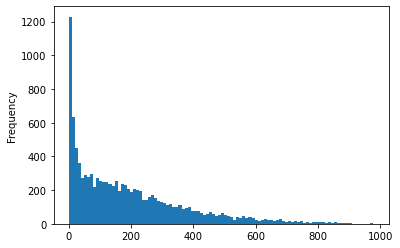

In [36]:
# Have a look at the output 'count'

df['count'].plot(kind = 'hist', bins=100);

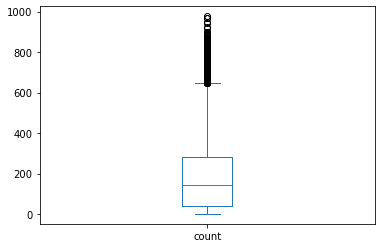

In [37]:
# check for outliers

df['count'].plot(kind = 'box');

In [28]:
# highly time-dependend count of rentals

px.line(data_frame=df, x='datetime', y=['casual', 'registered'])

In [9]:
#################################################
### Feature Engineering
#################################################

In [29]:
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [30]:
# create time based features: month, hour, year (overwrite season with month)
df = df.copy()

df.loc[:,'season'] = np.floor(df['datetime'].dt.month)
df.loc[:,'hour'] = df['datetime'].dt.hour
df.loc[:,'year'] = df['datetime'].dt.year

In [31]:
# binarize year

encoder = LabelBinarizer()
encoder.fit(df['year'])
encoder.classes_
df2 = pd.DataFrame(encoder.transform(df['year']), columns=["year_binary"])
df = pd.concat([df, df2], axis=1)

In [32]:
# Create poly features only for hour and season to make it possible to model high-order time-dependend nature of the signal

poly = PolynomialFeatures(degree=5)
poly.fit(df[['hour', 'season']])
time_poly = poly.transform(df[['hour', 'season']]);
df_time_poly = pd.DataFrame(time_poly, columns=poly.get_feature_names())

df = pd.concat([df, df_time_poly], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [33]:
# drop features

df.drop('datetime', axis=1, inplace=True)
df.drop('atemp', axis=1, inplace=True)
#df.drop('season_1.0', axis=1, inplace=True)
#df.drop('season', axis=1, inplace=True)
#df.drop('time_of_day_0.0', axis=1, inplace=True)
#df.drop('time_of_day', axis=1, inplace=True)
#df.drop('hour', axis=1, inplace=True)
#df.drop('holiday', axis=1, inplace=True)
#df.drop('workingday', axis=1, inplace=True)
df.drop('year', axis=1, inplace=True)


In [34]:
df.sample(5)

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,...,x0^3 x1,x0^2 x1^2,x0 x1^3,x1^4,x0^5,x0^4 x1,x0^3 x1^2,x0^2 x1^3,x0 x1^4,x1^5
5298,12.0,0,1,2,13.94,66,7.0015,6,169,175,...,96000.0,57600.0,34560.0,20736.0,3200000.0,1920000.0,1152000.0,691200.0,414720.0,248832.0
6849,4.0,0,1,1,25.42,17,12.9980,123,634,757,...,19652.0,4624.0,1088.0,256.0,1419857.0,334084.0,78608.0,18496.0,4352.0,1024.0
7549,5.0,0,0,2,25.42,61,11.0014,42,89,131,...,53240.0,12100.0,2750.0,625.0,5153632.0,1171280.0,266200.0,60500.0,13750.0,3125.0
5712,1.0,0,1,3,13.12,70,32.9975,1,2,3,...,64.0,16.0,4.0,1.0,1024.0,256.0,64.0,16.0,4.0,1.0
941,3.0,0,1,1,10.66,23,0.0000,6,65,71,...,12288.0,2304.0,432.0,81.0,1048576.0,196608.0,36864.0,6912.0,1296.0,243.0


In [17]:
###############################################
### Fancy Windspeed Imputation with Regression model (inspired by: https://github.com/gauravbansal98/Bike-Sharing-Demand/blob/master/Bike%20Sharing%20Demand.ipynb)
###############################################

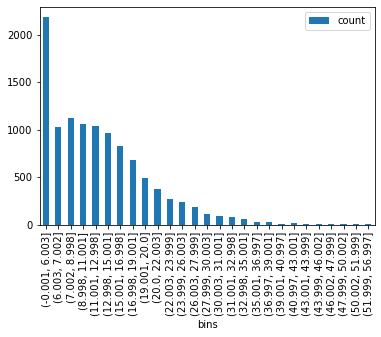

In [38]:
# plot the frequency of windspeeds before windspeed correction

bins = df.groupby('windspeed')['count'].count().index.values

df_bins = pd.DataFrame()
df_bins['count'] = df['count']
df_bins['bins'] = pd.cut(df['windspeed'], bins, include_lowest=True)
df_bins.groupby('bins').count().plot(kind='bar');

In [39]:
# Extract X and y values for training a model to correct wind speed

X_ws = df[df['windspeed'] != 0].drop(['windspeed', 'count', 'casual', 'registered'], axis=1)
y_ws = df[df['windspeed'] != 0]['windspeed']

In [40]:
# training and eval the windspeed model

m_ws = LinearRegression()
m_ws.fit(X_ws, y_ws)
m_ws.score(X_ws, y_ws)

0.16331647004156968

In [41]:
# predict windspeed values for all rows with ws = 0 and put them into the X-sets

df.loc[df['windspeed'] == 0, 'windspeed'] = m_ws.predict(df[df['windspeed'] == 0].drop(['windspeed', 'count', 'casual', 'registered'], axis=1))

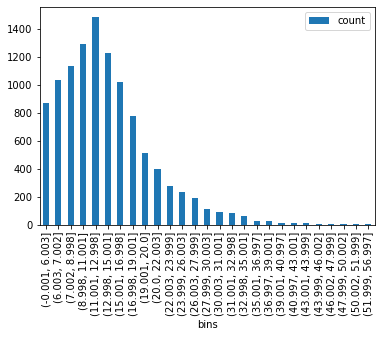

In [43]:
# plot the frequency of windspeeds AFTER windspeed correction

df_bins = pd.DataFrame()
df_bins['count'] = df['count']
df_bins['bins'] = pd.cut(df['windspeed'], bins, include_lowest=True)
df_bins.groupby('bins').count().plot(kind='bar');

In [23]:
############################################################
### Modelling
#####################################################

In [44]:
# Assign to X and y AND put log + 1 on the output (to normalize distribution)

X = df.drop(['registered', 'casual','count'], axis=1)
y = np.log1p(df['count'])

In [45]:
# Train/Test-split and checking of shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 30), (2178, 30), (8708,), (2178,))

In [46]:
# Scale train and test data

scaler = MinMaxScaler()
X_train[:] = scaler.fit_transform(X_train)
X_test[:] = scaler.transform(X_test)

In [47]:
# train and run model on actual data for "count"

model_lin = RandomForestRegressor()
model_lin.fit(X_train, y_train)
model_lin.score(X_train, y_train), model_lin.score(X_test, y_test)

(0.9921794809419348, 0.9490955075691664)

In [48]:
# perform some metrics, including the root mean square log error

y_hat = model_lin.predict(X_test)
r_square = r2_score(y_test, y_hat)
print('R²:\t' + str(r_square))
RMSLE = np.sqrt(mean_squared_log_error(y_test, y_hat))
print('RMSLE:\t' + str(RMSLE))

R²:	0.9490955075691664
RMSLE:	0.08329932515568363


In [29]:
############################################################
### Gradient Boosting Approach (manual)
#############################################################

In [30]:
# it turns out that the holiday/workday data improves the prediction 
# of the error very much, but has almost no influence of the accuracy 
# of the original model
# AND: the prediction of the error only works well with a 
# RandomForestRegressor

In [49]:
# creating a model to predict error

y_hat_train = model_lin.predict(X_train)
y_hat_test = model_lin.predict(X_test)
residues_1_train = y_train - y_hat_train
residues_1_test = y_test - y_hat_test

model_res_1 = RandomForestRegressor()
model_res_1.fit(X_train, residues_1_train)
model_res_1.score(X_train, residues_1_train), model_res_1.score(X_test, residues_1_test)

(0.8326904349883051, 0.024439253085969614)

In [50]:
# calculating the actual r² scores for the output

y_hat_boosted_train = y_hat_train + model_res_1.predict(X_train)
y_hat_boosted_test = y_hat_test + model_res_1.predict(X_test)
r2_score(y_train, y_hat_boosted_train), r2_score(y_test, y_hat_boosted_test)

(0.9986918113362964, 0.9503472615740288)

In [33]:
####################################################################
###################################################################
#### Kaggle Competition
##################################################################
##################################################################

In [51]:
# read in test dataset and repeat all the transformation steps

df = pd.read_csv('test.csv', index_col=0, parse_dates=True)
df.reset_index(inplace=True)

In [52]:
# create time-based features, overwrite season with month
df = df.copy()

df.loc[:,'season'] = np.floor(df['datetime'].dt.month/1)
df.loc[:,'hour'] = df['datetime'].dt.hour
#df.loc[:,'time_of_day'] = np.floor(df['hour']/1) 
df.loc[:,'year'] = df['datetime'].dt.year

In [53]:
# binarize year

encoder = LabelBinarizer()
encoder.fit(df['year'])
encoder.classes_
df2 = pd.DataFrame(encoder.transform(df['year']), columns=["year_binary"])
df = pd.concat([df, df2], axis=1)

In [54]:
# Create poly features only for hour and season

poly = PolynomialFeatures(degree=5)
poly.fit(df[['hour', 'season']])
time_poly = poly.transform(df[['hour', 'season']]);
df_time_poly = pd.DataFrame(time_poly, columns=poly.get_feature_names())

df = pd.concat([df, df_time_poly], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [55]:
# drop features

keep_dt = df['datetime']

df.drop('datetime', axis=1, inplace=True)
df.drop('atemp', axis=1, inplace=True)
#df.drop('season_1.0', axis=1, inplace=True)
#df.drop('season', axis=1, inplace=True)
#df.drop('time_of_day_0.0', axis=1, inplace=True)
#df.drop('time_of_day', axis=1, inplace=True)
#df.drop('hour', axis=1, inplace=True)
#df.drop('holiday', axis=1, inplace=True)
#df.drop('workingday', axis=1, inplace=True)
df.drop('year', axis=1, inplace=True)


In [56]:
df.sample(5)

,season,holiday,workingday,weather,temp,humidity,windspeed,hour,year_binary,1,...,x0^3 x1,x0^2 x1^2,x0 x1^3,x1^4,x0^5,x0^4 x1,x0^3 x1^2,x0^2 x1^3,x0 x1^4,x1^5
2854,11.0,0,0,1,20.50,63,23.9994,11,0,1.0,...,14641.0,14641.0,14641.0,14641.0,161051.0,161051.0,161051.0,161051.0,161051.0,161051.0
3213,12.0,0,0,1,18.86,51,22.0028,14,0,1.0,...,32928.0,28224.0,24192.0,20736.0,537824.0,460992.0,395136.0,338688.0,290304.0,248832.0
1413,6.0,0,1,1,28.70,48,8.9981,21,0,1.0,...,55566.0,15876.0,4536.0,1296.0,4084101.0,1166886.0,333396.0,95256.0,27216.0,7776.0
4784,6.0,0,1,1,25.42,61,7.0015,4,1,1.0,...,384.0,576.0,864.0,1296.0,1024.0,1536.0,2304.0,3456.0,5184.0,7776.0
530,3.0,0,1,2,16.40,58,16.9979,23,0,1.0,...,36501.0,4761.0,621.0,81.0,6436343.0,839523.0,109503.0,14283.0,1863.0,243.0


In [57]:
# predict windspeed values for all rows with ws = 0 and put them into the X-sets

df.loc[df['windspeed'] == 0, 'windspeed'] = m_ws.predict(df[df['windspeed'] == 0].drop('windspeed', axis=1))

In [58]:
X_test = df

In [59]:
# use scaler from above

X_test[:] = scaler.transform(X_test)

In [60]:
# make predictions on the whole test dataset and convert them back from log-format (exp())

output = pd.DataFrame()
output['datetime'] = keep_dt
output['count'] = np.expm1(model_lin.predict(X_test))


In [62]:
output.sample(5)

,datetime,count
6351,2012-12-26 02:00:00,2.435665
5627,2012-09-28 07:00:00,365.985952
3376,2012-01-26 09:00:00,260.344399
1220,2011-05-28 20:00:00,278.518602
2351,2011-09-29 12:00:00,213.418132


In [48]:
# save as csv and submit to kaggle.com

output.to_csv('predictions_bike_data_poly_time_features_RandomForestRegressor.csv', header=True, index=False)

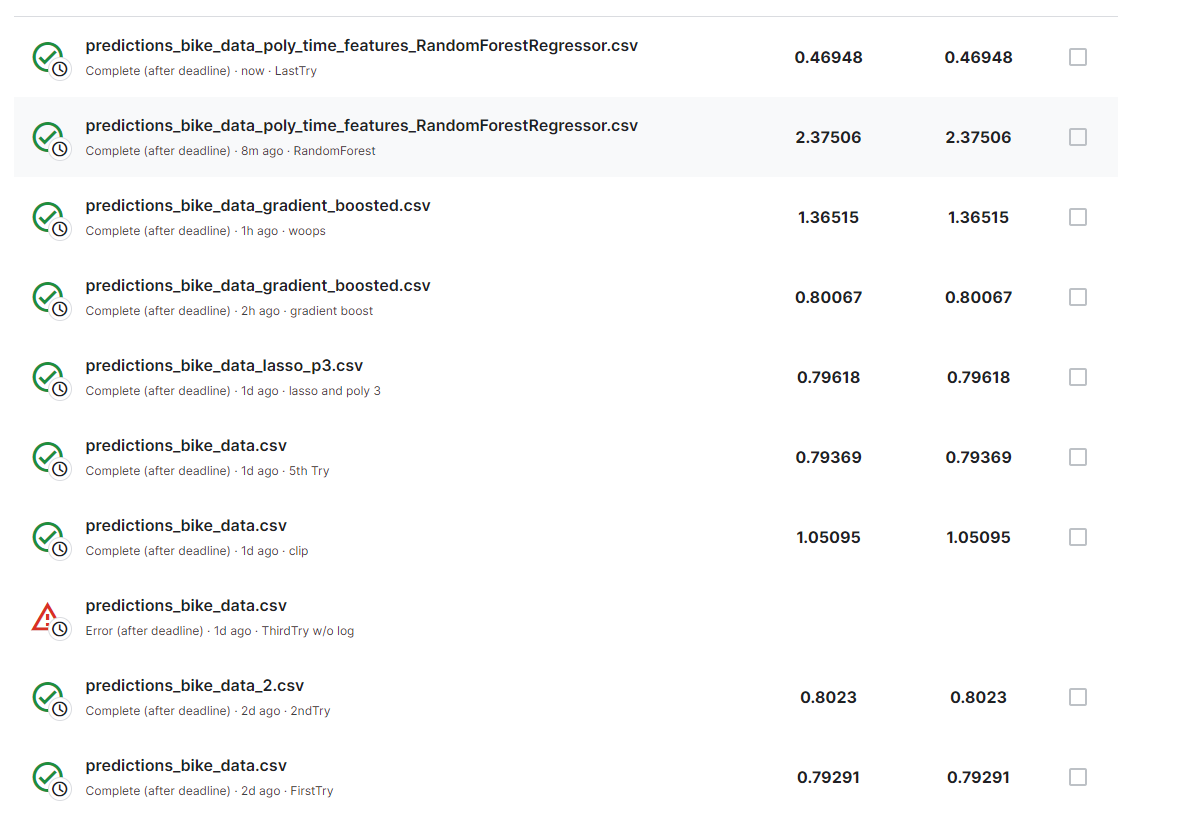